## First estimate straigh line segments

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import numpy.ma as ma

import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from datetime import datetime

### User input for straight line selection

In [2]:
flight_day = '2024-09-21'

bahamasFreq            = 100              # Hz
resamplingTime         =  60              # in seconds [interpolation/averaging interval of raw data]
minimumTimeForStraight =  10              # as number of resamplingTime intervalls
guessRange             =   4              # resampling intervalls before and after the estimated guess (not used currently)

In [3]:
resamplingTimeStr = str(resamplingTime)+'s'
trackResampling   = resamplingTime*bahamasFreq 

### Open file

In [4]:
flightID = "HALO-2024"+flight_day[5:7]+flight_day[8:10]+"a"

# ds = xr.open_zarr("ipns://latest.orcestra-campaign.org/products/HALO/position_attitude/"+flightID+".zarr")

root = "http://127.0.0.1:8080/ipfs"
ds = xr.open_zarr(f"{root}/QmUh1521G8ZJm6EftTohHfoV1LaqEewSspF9LPjm7Ypkvb")

roll = ds['roll'].resample(time=resamplingTimeStr).mean()
alt = ds.alt.resample(time=resamplingTimeStr).mean()

deltaHead = np.diff(ds.heading,n=1)
deltaHead = np.insert(deltaHead,0,0)
deltaHead = np.where( (deltaHead >  359) , deltaHead-360, deltaHead)
deltaHead = np.where( (deltaHead < -359) , deltaHead+360, deltaHead)

deltahead = [deltaHead[i:trackResampling+i].mean() for i in range(0,deltaHead.size,trackResampling)]
deltahead = np.insert(deltahead,0,0)

### Open dropsonde data

In [5]:
# dropsonde data

#root = "ipns://latest.orcestra-campaign.org"
# root = "ipfs://QmdU6gWEBywHsbV5c1A5tfopdTUBptF7m7Z2LmqYFm5pFw"
# all_sondes = xr.open_zarr(
#     f"{root}/products/HALO/dropsondes/Level_3/PERCUSION_Level_3.zarr"
# )
root = "http://127.0.0.1:8080/ipfs"
all_sondes = xr.open_zarr(f"{root}/QmdrTjLa5yG3woQc2wisWeCzEQjjg8zVTa9wQApWz3FsBK")

all_sondes

<xarray.Dataset> Size: 243MB
Dimensions:                (sonde_id: 989, alt: 1460)
Coordinates:
    aircraft_latitude      (sonde_id) float32 4kB dask.array<chunksize=(256,), meta=np.ndarray>
    aircraft_longitude     (sonde_id) float32 4kB dask.array<chunksize=(256,), meta=np.ndarray>
    aircraft_msl_altitude  (sonde_id) float32 4kB dask.array<chunksize=(256,), meta=np.ndarray>
  * alt                    (alt) float64 12kB 0.0 10.0 ... 1.458e+04 1.459e+04
    launch_time            (sonde_id) datetime64[ns] 8kB dask.array<chunksize=(256,), meta=np.ndarray>
  * sonde_id               (sonde_id) <U9 36kB '234150033' ... '232320070'
Data variables: (12/28)
    Np                     (sonde_id, alt) int64 12MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    Nq                     (sonde_id, alt) int64 12MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    Nrh                    (sonde_id, alt) int64 12MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    Nta                    (sonde_id, alt) int64 12MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    Ntheta                 (sonde_id, alt) int64 12MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    Nu                     (sonde_id, alt) int64 12MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    ...                     ...
    ta                     (sonde_id, alt) float32 6MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    theta                  (sonde_id, alt) float32 6MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    u                      (sonde_id, alt) float32 6MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    v                      (sonde_id, alt) float32 6MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    w_dir                  (sonde_id, alt) float32 6MB dask.array<chunksize=(256, 400), meta=np.ndarray>
    w_spd                  (sonde_id, alt) float32 6MB dask.array<chunksize=(256, 400), meta=np.ndarray>
Attributes:
    authors:        Helene Gloeckner Nina Robbins Theresa Mieslinger
    contact_email:  helene.gloeckner@mpimet.mpg.de
    version:        0.0.0.post289.dev0+5ff6816

### select sondes from the date of interest

In [6]:
flight_sondes = all_sondes.swap_dims({"sonde_id": "launch_time"}).sortby("launch_time").sel(launch_time=flight_day)

### Plot axis scaling

In [7]:
minlat = np.min(ds.lat.values)
maxlat = np.max(ds.lat.values)
minlon = np.min(ds.lon.values)
maxlon = np.max(ds.lon.values)

xs=round(maxlon-minlon)
ys=round(maxlat-minlat)

### Plot full flight track

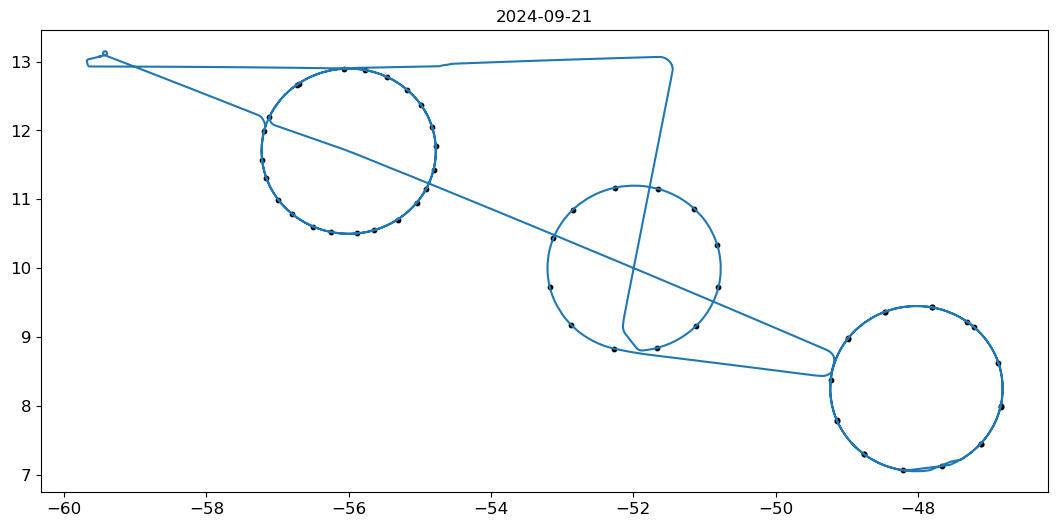

In [8]:
fig = plt.figure(figsize=(xs,ys))
ax = fig.add_subplot()

plt.xticks(fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

ax.plot(ds.lon,ds.lat)
ax.scatter(flight_sondes.aircraft_longitude, flight_sondes.aircraft_latitude, s = 10, color = 'k')

plt.title(f"{pd.Timestamp(ds.time.values[0]).to_pydatetime():%Y-%m-%d}")
plt.show()

### Flight altitude difference

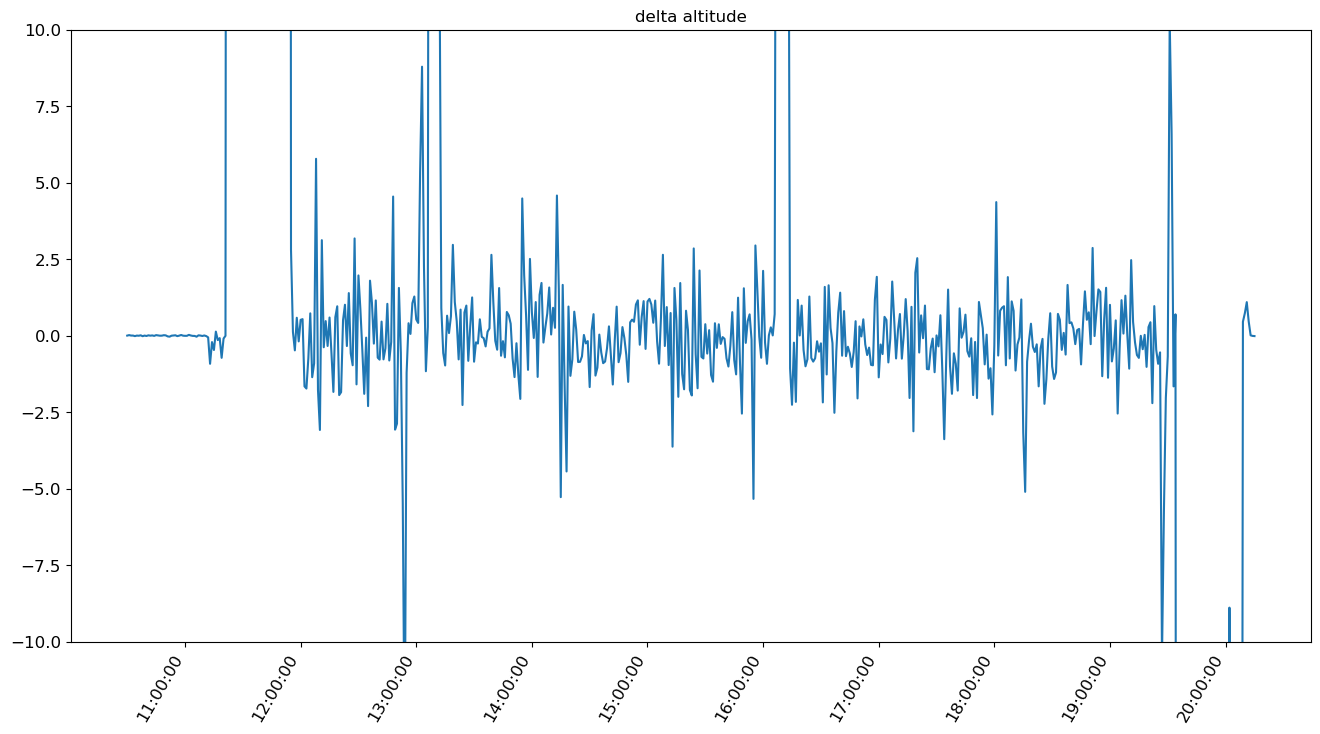

In [9]:
deltaalt = np.diff(alt,n=1)
deltaalt = np.insert(deltaalt,0,0)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

resamplingTimeStr= str(resamplingTime)+'s'
ax.plot(alt.time,deltaalt)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.ylim((-10,10))

plt.title("delta altitude")
plt.show()

### Delta flight heading

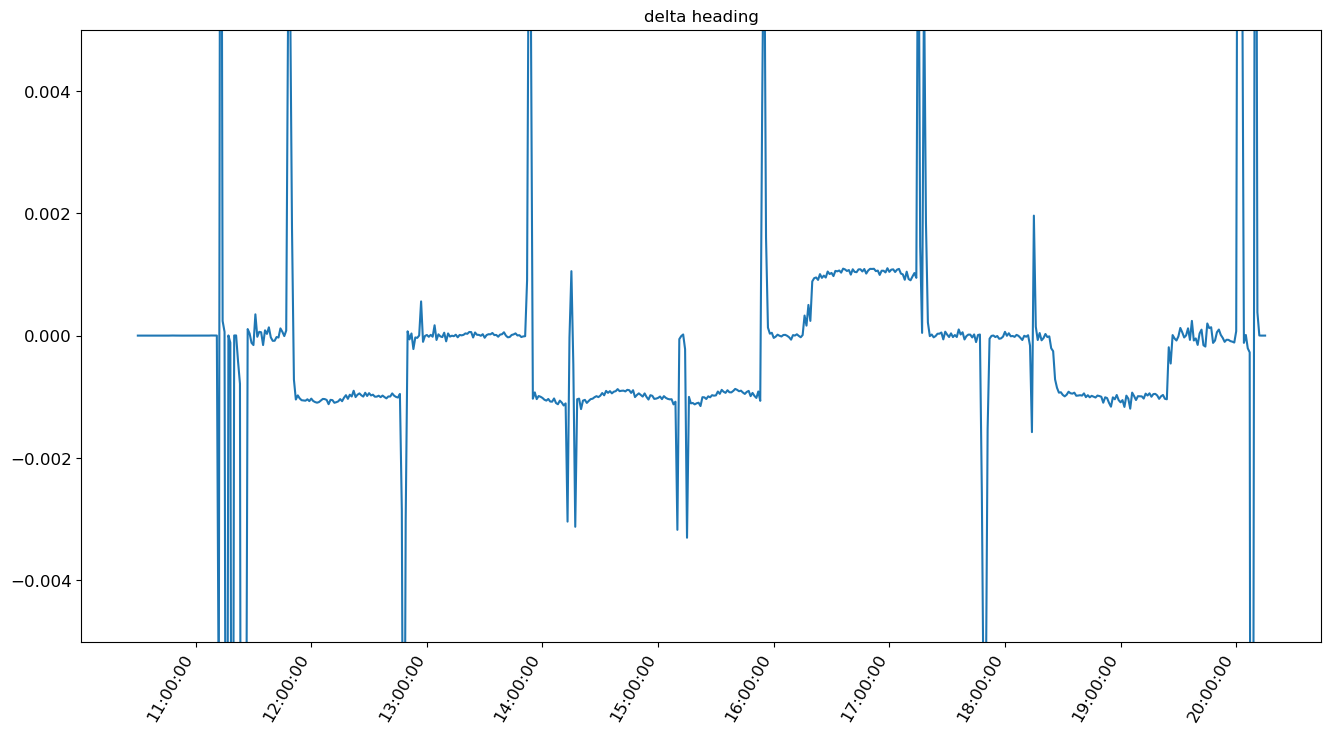

In [10]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(alt.time,deltahead)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)

plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.ylim((-0.005,0.005))

plt.title("delta heading")

plt.show()

### Flight roll

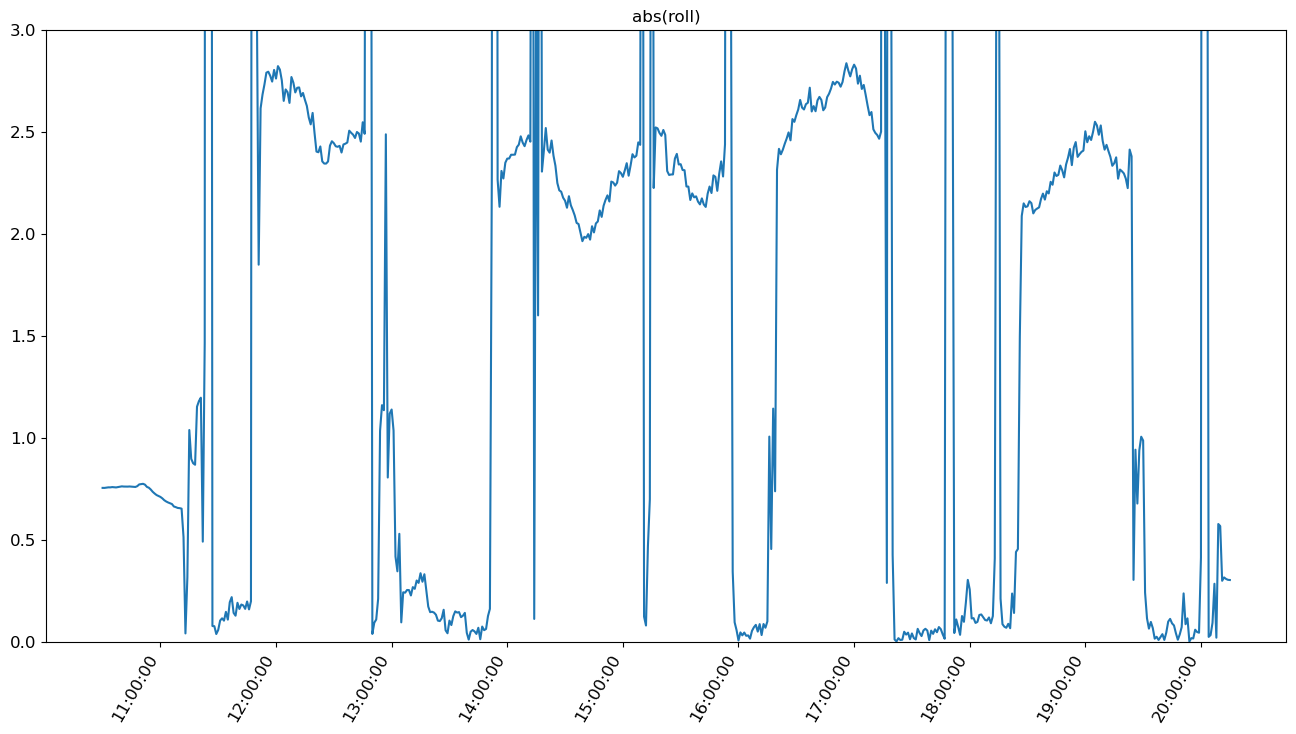

In [11]:
roll = abs(roll)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(roll.time,roll)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)
plt.ylim((0,3))

plt.title("abs(roll)")
plt.show()

### Now get to the lines

In [12]:
dheadmin=-0.003
dheadmax=0.003

straight = np.ma.masked_where( ( deltahead < dheadmin ) | ( deltahead > dheadmax ) | ( deltaalt < 5 ) & ( roll < 0.3 ), deltahead )
slices = np.ma.flatnotmasked_contiguous(straight)

slices_start = np.array([s.start for s in slices])
slices_end   = np.array([s.stop  for s in slices])

j=0
segment=0
for i in slices_start:
    ibeg=i
    iend=slices_end[j]
    straight_length = iend-ibeg+1
    j += 1

    iendtim = min(iend*trackResampling,ds.time.size-1)
    straight_start = ds.time[ibeg*trackResampling]
    straight_stop  = ds.time[iendtim]

    if ( straight_length <= minimumTimeForStraight ) :
        for index in range(ibeg, iend):
            straight.mask[index] = True
    else :
        print (f"{pd.Timestamp(straight_start.time.values).to_pydatetime():%H:%M:%S}" , " to ",
               f"{pd.Timestamp(straight_stop.time.values).to_pydatetime():%H:%M:%S}")
        segment += 1 

10:30:58  to  11:12:58
11:27:58  to  11:48:58
11:50:58  to  12:48:58
12:54:58  to  13:05:58
13:55:58  to  14:13:58
14:18:58  to  15:10:58
15:16:58  to  15:54:58
16:16:58  to  17:15:58
18:24:58  to  19:33:58


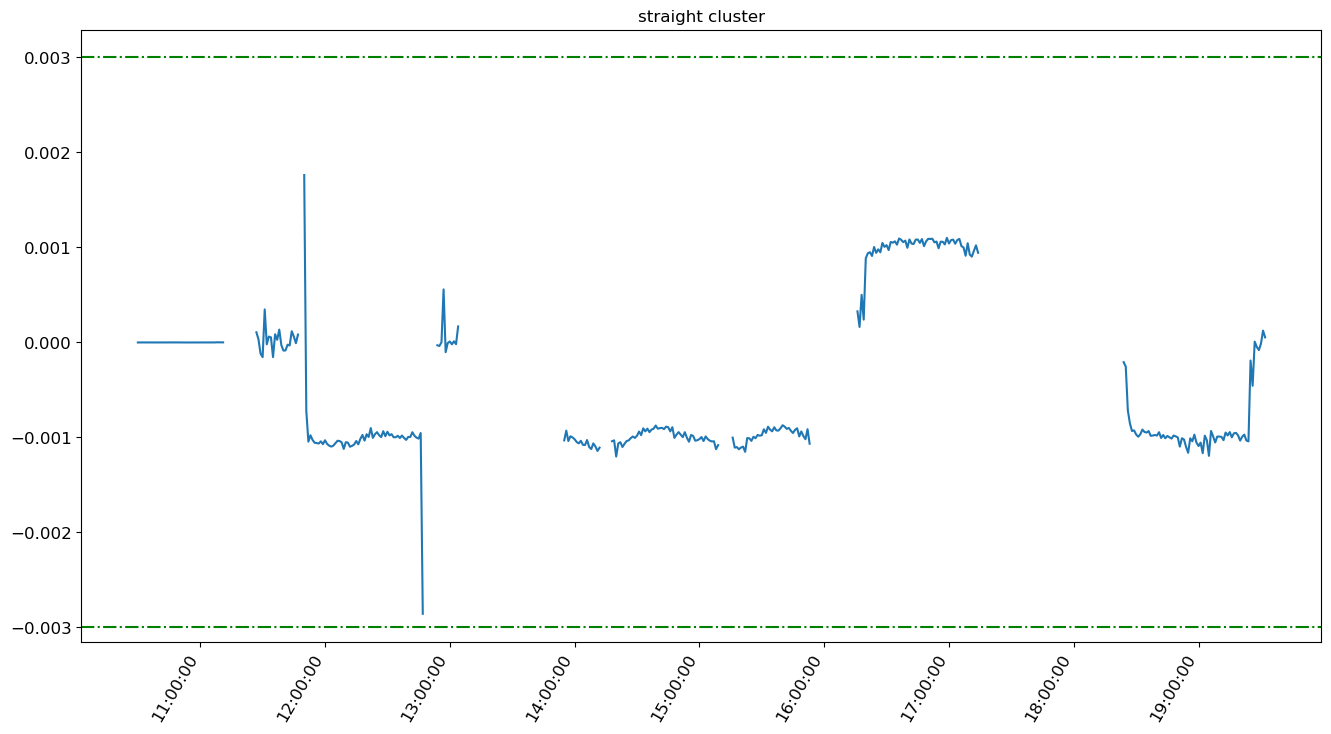

In [13]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

ax.plot(alt.time,straight)

timeFmt = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(timeFmt)
plt.gcf().autofmt_xdate()

plt.xticks(rotation=60, fontweight='light', fontsize=12)
plt.yticks(fontweight='light', fontsize=12)

plt.axhline(y=dheadmax, color='g', linestyle='-.')
plt.axhline(y=dheadmin, color='g', linestyle='-.')

plt.title("straight cluster")
plt.show()

### Start of straight line

10:30:58  to  11:12:58
11:27:58  to  11:48:58
11:50:58  to  12:48:58
12:54:58  to  13:05:58
13:55:58  to  14:13:58
14:18:58  to  15:10:58
15:16:58  to  15:54:58
16:16:58  to  17:15:58
18:24:58  to  19:33:58


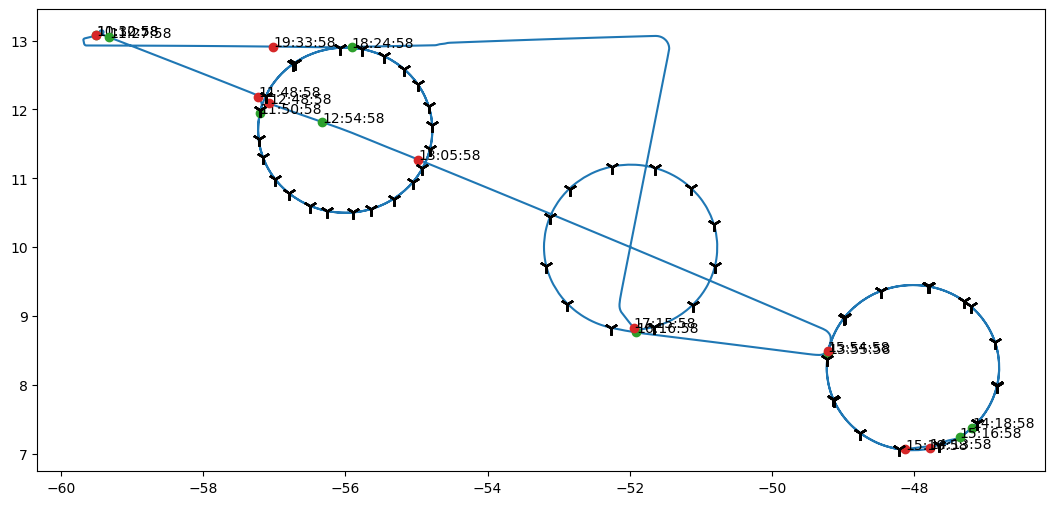

In [14]:
j=0
guessRange=0

fig = plt.figure(figsize=(xs,ys))
ax = fig.add_subplot()

ax.plot(ds.lon, ds.lat)

for i in slices_start:

    ibeg=i
    iend=slices_end[j]
    iendtim = min(iend*trackResampling,ds.time.size-1)

    straight_length = iend-ibeg+1
    straight_start_mid = ds.time[ibeg*trackResampling]
    straight_end_mid   = ds.time[iendtim]

    if ( straight_length > minimumTimeForStraight ) :

        print (f"{pd.Timestamp(straight_start_mid.time.values).to_pydatetime():%H:%M:%S}" , " to ",
               f"{pd.Timestamp(straight_end_mid.time.values).to_pydatetime():%H:%M:%S}")

        point_start_mid = ds.isel(time=(ibeg*trackResampling))

        ax.scatter(point_start_mid.lon, point_start_mid.lat, color="tab:green", zorder=3)
        ax.text   (point_start_mid.lon, point_start_mid.lat, f"{pd.Timestamp(straight_start_mid.time.values).to_pydatetime():%H:%M:%S}")

        point_end_mid = ds.isel(time=(iendtim))

        ax.scatter(point_end_mid.lon, point_end_mid.lat, color="tab:red", zorder=3)
        ax.text   (point_end_mid.lon, point_end_mid.lat, f"{pd.Timestamp(straight_end_mid.time.values).to_pydatetime():%H:%M:%S}")

        # plot sondes
        ax.scatter(flight_sondes.aircraft_longitude, flight_sondes.aircraft_latitude, marker = '1', s = 100, color = 'k', zorder=3)

        segment += 1

    j += 1

plt.show()